In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from sklearn.preprocessing import LabelEncoder
# from xgboost import XGBClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report
# from sklearn.metrics import confusion_matrix
# from tabulate import tabulate
# from sklearn.utils.class_weight import compute_sample_weight
# import seaborn as sns
# import joblib
# import os
from pandas.tseries.offsets import DateOffset
from markov_helpers import *

In [11]:
df = pd.read_csv(r'C:\Users\samvi\Documents\Coding Projects\Embedded Work\Data_Used\Training_Data.csv')

C:\Users\samvi\AppData\Local\Temp\ipykernel_41032\2712093529.py:1: DtypeWarning: Columns (16,23,30,33,36,37,38,39,40,41,42,43,44,50,53,55,58,59,60,65) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'C:\Users\samvi\Documents\Coding Projects\Embedded Work\Data_Used\Training_Data.csv')


In [12]:
df = add_next_state(df, 6)

In [13]:
le_state = LabelEncoder()
df['State Encoded'] = le_state.fit_transform(df['State'])
df['Next State Encoded'] = le_state.transform(df['Next State'])

In [14]:
pairs = {'Fixed': 0, 'ARM': 1}
df = encode_col(df, 'Interest Type', pairs, 'Interest Type Encoded')

pairs = {'Amortizing Balloon': 0, 'Interest Only/Amortizing/Balloon': 1, 'Interest Only/Balloon': 2, 'Fully Amortizing': 3, 'Interest Only/Fully Amortizing': 4}
df = encode_col(df, 'Amortization Type', pairs, 'Amortization Type Encoded')

In [15]:
feature_cols = ['State Encoded', 'Age', 'Original UPB', 'UPB - Current', 'Note Rate', 'Underwritten DSCR', 
                'Original Term', 'Loan Acquisition LTV', 'Proportion Through Loan', 'Amortization Type Encoded', 
                'Interest Type Encoded', 'Percentage Paid', 'Paid per Age', 
                'LTV_over_DSCR', 'NoteRate_over_DSCR', 'Current_LTV_Approx', 'LTV_times_DSCR']

X = df[feature_cols]
y = df['Next State Encoded']

In [16]:
df = downsample(df, 1000)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # ensures class balance in both sets
)

<class 'numpy.ndarray'>
(3938234,)
[0.21515255 0.21515255 0.21515255 0.21515255 0.21515255]


c:\Users\samvi\Documents\Coding Projects\Embedded Work\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:18:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


                     precision    recall  f1-score   support

            Current       0.98      0.79      0.87    915219
            Default       0.10      0.75      0.18      5944
        Foreclosure       0.17      0.96      0.29      1014
Fully Paid, Matured       0.42      1.00      0.59      5633
Fully Paid, Prepaid       0.20      0.68      0.31     56749

           accuracy                           0.78    984559
          macro avg       0.38      0.83      0.45    984559
       weighted avg       0.93      0.78      0.83    984559

Feature Importances:
[0.4810056  0.04465053 0.0150168  0.01473976 0.02533002 0.0161417
 0.03671178 0.02091356 0.14851247 0.02326178 0.04066206 0.02422387
 0.01717503 0.02592531 0.02793933 0.02054135 0.01724906]


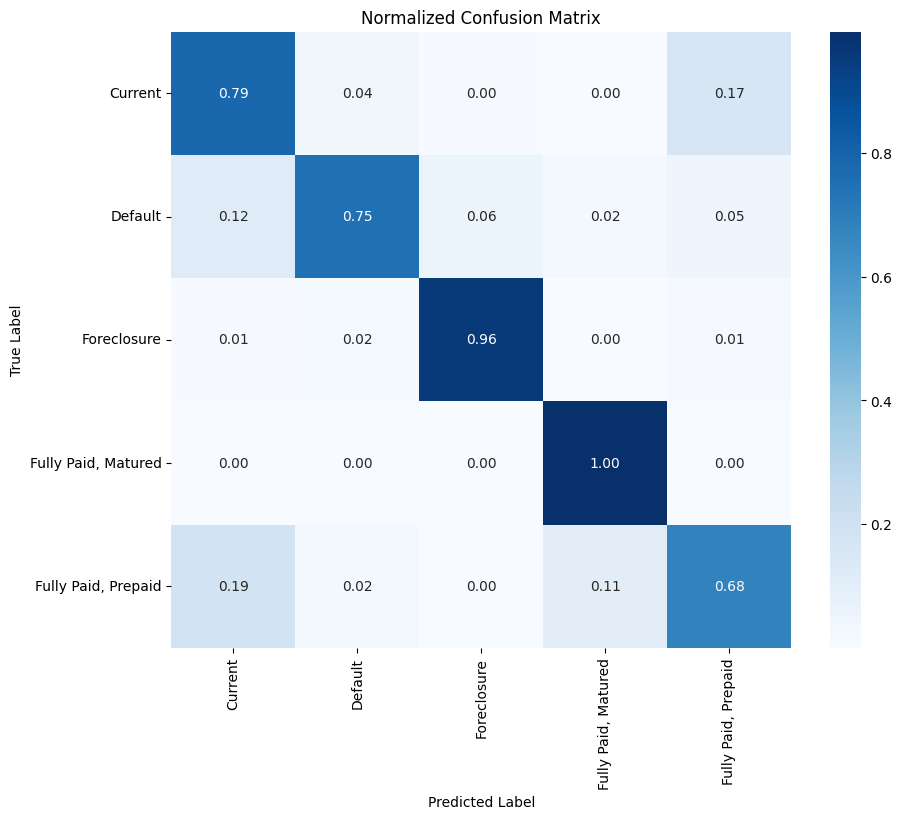

Classification Report:
                     precision  recall  f1-score    support
Current                  0.984   0.785     0.873  915219.00
Default                  0.103   0.748     0.182    5944.00
Foreclosure              0.167   0.960     0.285    1014.00
Fully Paid, Matured      0.421   0.996     0.592    5633.00
Fully Paid, Prepaid      0.201   0.682     0.311   56749.00
accuracy                 0.780   0.780     0.780       0.78
macro avg                0.375   0.834     0.449  984559.00
weighted avg             0.930   0.780     0.835  984559.00


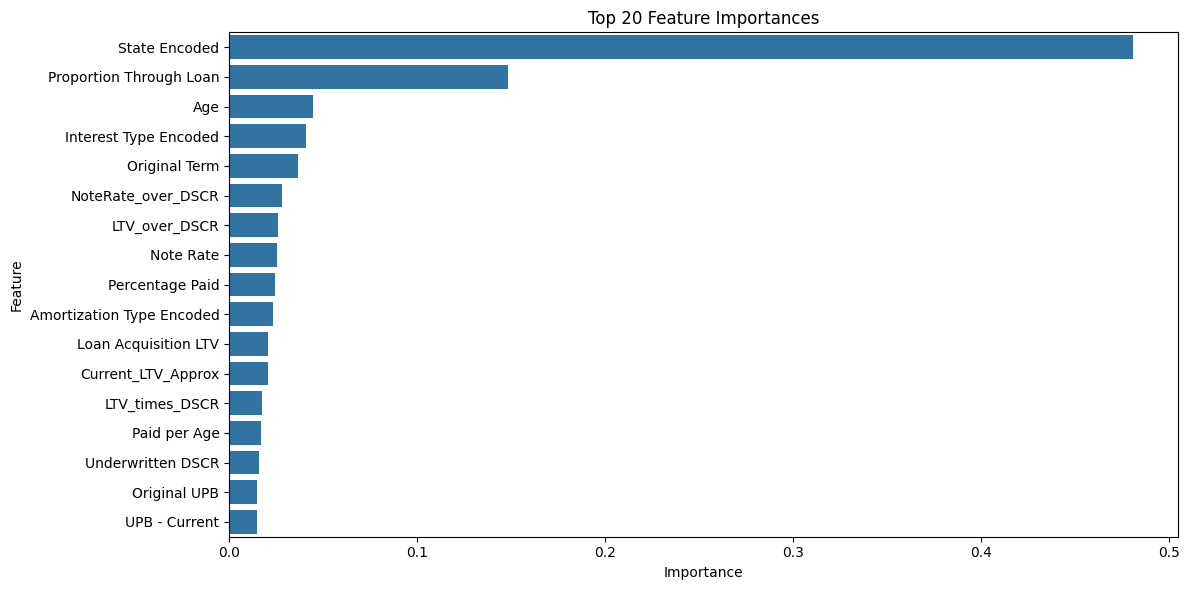

In [18]:
train_model(X, y, X_train, y_train, X_test, y_test, le_state)

In [25]:
df2 = df2[['Loan Number', 'Start', 'Stop', 'Age', 'State', 'Next State', 'Acquisition Date',
       'Note Date', 'Maturity Date at Acquisition', 'Loan Acquisition UPB',
       'Amortization Type', 'Interest Type', 'Loan Product Type',
       'Original UPB', 'Amortization Term', 'Original Interest Rate',
       'Lien Position', 'Transaction ID ', 'Issue Date',
       'Loan Acquisition LTV', 'Underwritten DSCR', 'Underwritten DSCR Type',
       'Original Term', 'Original I/O Term', 'I/O End Date',
       'Loan Ever 60+ Days Delinquent', 'Loss Sharing Type',
       'Modified Loss Sharing Percentage',
       'Number of Properties at Acquisition',
       'Property Acquisition Total Unit Count', 'Specific Property Type',
       'Year Built', 'Property City', 'Property State', 'Property Zip Code',
       'Metropolitan Statistical Area', 'Physical Occupancy %',
       'Liquidation/Prepayment Code', 'Liquidation/Prepayment Date',
       'Foreclosure Date', 'Credit Event Date', 'Foreclosure Value',
       'Lifetime Net Credit Loss Amount', 'Sale Price', 'Default Amount',
       'Credit Event Type', 'Reporting Period Date',
       'Loan Active Property Count', 'Note Rate', 'Maturity Date - Current',
       'UPB - Current', 'Delinquency UPB', 'Loan Payment Status',
       'SDQ Indicator', 'Most Recent Modification Date',
       'Modification Indicator', 'Defeasance Date', 'Prepayment Provision',
       'Prepayment Provision End Date', 'Affordable Housing Type',
       'MCIRT Deal ID', 'MCAS Deal ID', 'DUS Prepayment Outcomes',
       'DUS Prepayment Segments', 'Loan Age', 'Green Bond Indicator',
       'Social Bond Indicator', 'Proportion Through Loan', 'Percentage Paid',
       'Paid per Age', 'LTV_over_DSCR', 'NoteRate_over_DSCR',
       'Current_LTV_Approx', 'LTV_times_DSCR']]

In [27]:
df2[df2['Loan Number'] == 1682079906].tail(20)

,Loan Number,Start,Stop,Age,State,Next State,Acquisition Date,Note Date,Maturity Date at Acquisition,Loan Acquisition UPB,Amortization Type,Interest Type,Loan Product Type,Original UPB,Amortization Term,Original Interest Rate,Lien Position,Transaction ID,Issue Date,Loan Acquisition LTV,Underwritten DSCR,Underwritten DSCR Type,Original Term,Original I/O Term,I/O End Date,Loan Ever 60+ Days Delinquent,Loss Sharing Type,Modified Loss Sharing Percentage,Number of Properties at Acquisition,Property Acquisition Total Unit Count,Specific Property Type,Year Built,Property City,Property State,Property Zip Code,Metropolitan Statistical Area,Physical Occupancy %,Liquidation/Prepayment Code,Liquidation/Prepayment Date,Foreclosure Date,Credit Event Date,Foreclosure Value,Lifetime Net Credit Loss Amount,Sale Price,Default Amount,Credit Event Type,Reporting Period Date,Loan Active Property Count,Note Rate,Maturity Date - Current,UPB - Current,Delinquency UPB,Loan Payment Status,SDQ Indicator,Most Recent Modification Date,Modification Indicator,Defeasance Date,Prepayment Provision,Prepayment Provision End Date,Affordable Housing Type,MCIRT Deal ID,MCAS Deal ID,DUS Prepayment Outcomes,DUS Prepayment Segments,Loan Age,Green Bond Indicator,Social Bond Indicator,Proportion Through Loan,Percentage Paid,Paid per Age,LTV_over_DSCR,NoteRate_over_DSCR,Current_LTV_Approx,LTV_times_DSCR
323022,1682079906,56,57,56,Current,Current,2002-08-01,2002-07-12,2012-11-01,"$2,205,000.00",Amortizing Balloon,Fixed,DUS,2205000.0,360.0,7.285,Second,385373,2002-08-01,80.0,1.25,Lender UW DSCR,123.0,NaN,NaN,Y,Pari Passu,NaN,1.0,780.0,Multifamily,1978,HOUSTON,TX,77074,"HOUSTON-THE WOODLANDS-SUGAR LAND, TX METROPOLI...",0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,REO,2007-04-01,1.0,7.285,2012-11-01,2104028.51,NaN,Current,N,NaN,N,NaN,"YM(117), O*(6)",NaN,NaN,NaN,NaN,Involuntary Prepayment,Standard,75.0,N,NaN,0.459677,0.045792,0.000818,64.0,5.828,76.336635,100.0
323023,1682079906,57,58,57,Current,Current,2002-08-01,2002-07-12,2012-11-01,"$2,205,000.00",Amortizing Balloon,Fixed,DUS,2205000.0,360.0,7.285,Second,385373,2002-08-01,80.0,1.25,Lender UW DSCR,123.0,NaN,NaN,Y,Pari Passu,NaN,1.0,780.0,Multifamily,1978,HOUSTON,TX,77074,"HOUSTON-THE WOODLANDS-SUGAR LAND, TX METROPOLI...",0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,REO,2007-05-01,1.0,7.285,2012-11-01,2101707.35,NaN,Current,N,NaN,N,NaN,"YM(117), O*(6)",NaN,NaN,NaN,NaN,Involuntary Prepayment,Standard,75.0,N,NaN,0.467742,0.046845,0.000822,64.0,5.828,76.252421,100.0
323024,1682079906,58,59,58,Current,Current,2002-08-01,2002-07-12,2012-11-01,"$2,205,000.00",Amortizing Balloon,Fixed,DUS,2205000.0,360.0,7.285,Second,385373,2002-08-01,80.0,1.25,Lender UW DSCR,123.0,NaN,NaN,Y,Pari Passu,NaN,1.0,780.0,Multifamily,1978,HOUSTON,TX,77074,"HOUSTON-THE WOODLANDS-SUGAR LAND, TX METROPOLI...",0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,REO,2007-06-01,1.0,7.285,2012-11-01,2099797.40,NaN,Current,N,NaN,N,NaN,"YM(117), O*(6)",NaN,NaN,NaN,NaN,Involuntary Prepayment,Standard,75.0,N,NaN,0.475806,0.047711,0.000823,64.0,5.828,76.183126,100.0
323025,1682079906,59,60,59,Current,Current,2002-08-01,2002-07-12,2012-11-01,"$2,205,000.00",Amortizing Balloon,Fixed,DUS,2205000.0,360.0,7.285,Second,385373,2002-08-01,80.0,1.25,Lender UW DSCR,123.0,NaN,NaN,Y,Pari Passu,NaN,1.0,780.0,Multifamily,1978,HOUSTON,TX,77074,"HOUSTON-THE WOODLANDS-SUGAR LAND, TX METROPOLI...",0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,REO,2007-07-01,1.0,7.285,2012-11-01,2097450.55,NaN,Current,N,NaN,N,NaN,"YM(117), O*(6)",NaN,NaN,NaN,NaN,Involuntary Prepayment,Standard,75.0,N,NaN,0.483871,0.048775,0.000827,64.0,5.828,76.097979,100.0
323026,1682079906,60,61,60,Current,Current,2002-08-01,2002-07-12,2012-11-01,"$2,205,000.00",Amortizing Balloon,Fixed,DUS,2205000.0,360.0,7.285,Second,385373,2002-08-01,80.0,1.25,Lender UW DSCR,123.0,NaN,NaN,Y,Pari Passu,NaN,1.0,780.0,Multifamily,1978,HOUSTON,TX,77074,"HOUSTON-THE WOODLANDS-SUGAR LAND, TX METROPOLI...",0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,REO,2007-08-01,1.0,7.285,2012-11-